In [376]:
import pickle
import numpy as np
import glob
import pandas as pd
import torch
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.pyplot as plt

In [377]:
results_path = 'test_results.pkl'
image_detection_data_path = '../data/Potholes/Proposals_test/test_detection/*'

In [378]:
# result = [predicted, label, path]
with open(results_path, "rb") as f:
    results = pickle.load(f)

# list[pkl]
image_detection_data_list = glob.glob(image_detection_data_path)

In [379]:
results_df = pd.DataFrame(results, columns=['predicted', 'label', 'confidence', 'proposal_path'])

In [380]:
results_df['proposal_path'] = results_df['proposal_path'].apply(lambda x: x.split('/')[-1])

In [381]:
rows = []

for image_detection_data_pkl in image_detection_data_list:
    img_id = int(image_detection_data_pkl.split('-')[-1].split('_')[0])
    
    with open(image_detection_data_pkl, "rb") as f:
        image_detection_data = pickle.load(f)
    
    groundtruth = image_detection_data['groundtruth']
    proposals = image_detection_data['proposals']
    
    max_len = max(len(groundtruth), len(proposals))
    
    for i in range(max_len):
        gt = groundtruth[i] if i < len(groundtruth) else None
        prop = proposals[i] if i < len(proposals) else None
        rows.append({
            'img_id': img_id,
            'groundtruth': gt,
            'proposals': prop
        })

image_detection_df = pd.DataFrame(rows)

In [382]:
image_detection_df['proposals'] = image_detection_df['proposals'].apply(lambda x: x if x is not None else [None, None])

image_detection_df[['proposal_path', 'proposal_bbox']] = pd.DataFrame(
    image_detection_df['proposals'].tolist(),
    index=image_detection_df.index
)

image_detection_df.drop(columns='proposals', inplace=True)

In [383]:
def convert_groundtruth(x):
    if x is None:  # Handle None values
        return None
    return [val.item() if isinstance(val, torch.Tensor) else val for val in x]

image_detection_df['groundtruth'] = image_detection_df['groundtruth'].apply(convert_groundtruth)


In [384]:
# Merge the two DataFrames
merged_df = pd.merge(image_detection_df, results_df, on='proposal_path', how='inner')

In [385]:
merged_df.head(20)

img_id                   groundtruth            proposal_path  \
0      268  [258.0, 195.0, 494.0, 414.0]   img-268_proposal_0.jpg   
1      268                          None   img-268_proposal_1.jpg   
2      268                          None   img-268_proposal_2.jpg   
3      268                          None   img-268_proposal_3.jpg   
4      268                          None   img-268_proposal_4.jpg   
5      268                          None   img-268_proposal_5.jpg   
6      268                          None   img-268_proposal_6.jpg   
7      268                          None   img-268_proposal_7.jpg   
8      268                          None   img-268_proposal_8.jpg   
9      268                          None   img-268_proposal_9.jpg   
10     268                          None  img-268_proposal_10.jpg   
11     268                          None  img-268_proposal_11.jpg   
12     268                          None  img-268_proposal_12.jpg   
13     268                          None  img-268_proposal_13.jpg   
14     268                          None  img-268_proposal_14.jpg   
15     205  [274.0, 166.0, 715.0, 384.0]   img-205_proposal_0.jpg   
16     205    [0.0, 412.0, 326.0, 607.0]   img-205_proposal_1.jpg   
17     205                          None   img-205_proposal_2.jpg   
18     205                          None   img-205_proposal_3.jpg   
19     205                          None   img-205_proposal_4.jpg   

           proposal_bbox predicted label                     confidence  
0   [258, 191, 498, 407]       0.0     0   [[0.9999882, 6.5435197e-06]]  
1   [258, 199, 498, 406]       0.0     0   [[0.99997747, 1.193293e-05]]  
2   [258, 201, 498, 406]       0.0     0   [[0.9999751, 1.3698315e-05]]  
3   [252, 194, 502, 407]       0.0     0   [[0.9999924, 3.8578933e-06]]  
4   [252, 188, 502, 407]       0.0     0   [[0.99998415, 8.343707e-06]]  
5   [269, 201, 498, 406]       0.0     0   [[0.99988914, 6.315207e-05]]  
6   [274, 191, 498, 407]       0.0     0     [[0.999902, 5.887057e-05]]  
7   [252, 194, 486, 397]       0.0     0     [[0.9998815, 6.22956e-05]]  
8   [252, 175, 505, 407]       0.0     0   [[0.99990904, 5.248684e-05]]  
9   [231, 188, 502, 407]       0.0     0   [[0.9998147, 0.00012393312]]  
10  [346, 300, 505, 407]       0.0     1      [[0.73871654, 0.2817448]]  
11  [346, 301, 505, 407]       0.0     1      [[0.8507464, 0.15975259]]  
12  [299, 285, 424, 407]       1.0     1     [[0.0038828403, 0.996534]]  
13  [346, 303, 502, 407]       0.0     1    [[0.98271585, 0.015816031]]  
14  [361, 283, 486, 385]       1.0     1     [[0.08050226, 0.92935115]]  
15  [290, 163, 720, 402]       0.0     0   [[0.9999367, 3.8774382e-05]]  
16  [319, 163, 720, 379]       0.0     0  [[0.99927324, 0.00043929758]]  
17    [0, 408, 335, 631]       0.0     0  [[0.99940836, 0.00032561334]]  
18    [0, 396, 346, 597]       0.0     0   [[0.99521846, 0.0030810987]]  
19  [301, 154, 720, 406]       0.0     0   [[0.9997973, 0.00013921117]]

In [386]:
merged_df['confidence'] = merged_df['confidence'].apply(lambda x: max(x[0]))

In [387]:
merged_df.head(20)

result_df_without_nms = merged_df.copy()


In [388]:
def calculate_iou(box1, box2):
        
    box1 = [int(x) for x in box1]
    box2 = [int(x) for x in box2]
    
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = box1_area + box2_area - intersection
    
    return intersection / union if union > 0 else 0

def apply_nms(df, iou_threshold=0.5, confidence_threshold=0.5):
    result_df = df.copy()
    
    for img_id in df['img_id'].unique():
        img_mask = result_df['img_id'] == img_id
        img_df = result_df[img_mask].copy()
        
        valid_mask = img_df['confidence'] >= confidence_threshold
        valid_indices = img_df[valid_mask].index
        
        if len(valid_indices) == 0:
            result_df.loc[img_mask, 'proposal_bbox'] = None
            continue
            
        sorted_indices = valid_indices[(-img_df.loc[valid_indices, 'confidence']).argsort()]
        
        kept_indices = []
        suppressed_indices = []
        
        for idx in sorted_indices:
            if idx in suppressed_indices:
                continue
                
            kept_indices.append(idx)
            current_box = result_df.loc[idx, 'proposal_bbox']
            
            for other_idx in sorted_indices:
                if other_idx == idx or other_idx in suppressed_indices:
                    continue
                    
                other_box = result_df.loc[other_idx, 'proposal_bbox']
                iou = calculate_iou(current_box, other_box)
                
                if iou > iou_threshold:
                    suppressed_indices.append(other_idx)

        result_df.loc[suppressed_indices, 'proposal_bbox'] = None
        low_conf_indices = img_df[~valid_mask].index
        result_df.loc[low_conf_indices, 'proposal_bbox'] = None
    
    return result_df

In [389]:
result_df = apply_nms(merged_df, confidence_threshold=0.5)

In [390]:
result_df.head(40)

img_id                   groundtruth            proposal_path  \
0      268  [258.0, 195.0, 494.0, 414.0]   img-268_proposal_0.jpg   
1      268                          None   img-268_proposal_1.jpg   
2      268                          None   img-268_proposal_2.jpg   
3      268                          None   img-268_proposal_3.jpg   
4      268                          None   img-268_proposal_4.jpg   
5      268                          None   img-268_proposal_5.jpg   
6      268                          None   img-268_proposal_6.jpg   
7      268                          None   img-268_proposal_7.jpg   
8      268                          None   img-268_proposal_8.jpg   
9      268                          None   img-268_proposal_9.jpg   
10     268                          None  img-268_proposal_10.jpg   
11     268                          None  img-268_proposal_11.jpg   
12     268                          None  img-268_proposal_12.jpg   
13     268                          None  img-268_proposal_13.jpg   
14     268                          None  img-268_proposal_14.jpg   
15     205  [274.0, 166.0, 715.0, 384.0]   img-205_proposal_0.jpg   
16     205    [0.0, 412.0, 326.0, 607.0]   img-205_proposal_1.jpg   
17     205                          None   img-205_proposal_2.jpg   
18     205                          None   img-205_proposal_3.jpg   
19     205                          None   img-205_proposal_4.jpg   
20     205                          None   img-205_proposal_5.jpg   
21     205                          None   img-205_proposal_6.jpg   
22     205                          None   img-205_proposal_7.jpg   
23     205                          None   img-205_proposal_8.jpg   
24     205                          None   img-205_proposal_9.jpg   
25     205                          None  img-205_proposal_10.jpg   
26     205                          None  img-205_proposal_11.jpg   
27     205                          None  img-205_proposal_12.jpg   
28     205                          None  img-205_proposal_13.jpg   
29     205                          None  img-205_proposal_14.jpg   
30     263  [228.0, 241.0, 444.0, 362.0]   img-263_proposal_0.jpg   
31     263                          None   img-263_proposal_1.jpg   
32     263                          None   img-263_proposal_2.jpg   
33     263                          None   img-263_proposal_3.jpg   
34     263                          None   img-263_proposal_4.jpg   
35     263                          None   img-263_proposal_5.jpg   
36     263                          None   img-263_proposal_6.jpg   
37     263                          None   img-263_proposal_7.jpg   
38     263                          None   img-263_proposal_8.jpg   
39     263                          None   img-263_proposal_9.jpg   

           proposal_bbox predicted label  confidence  
0                   None       0.0     0    0.999988  
1                   None       0.0     0    0.999977  
2                   None       0.0     0    0.999975  
3   [252, 194, 502, 407]       0.0     0    0.999992  
4                   None       0.0     0    0.999984  
5                   None       0.0     0    0.999889  
6                   None       0.0     0    0.999902  
7                   None       0.0     0    0.999882  
8                   None       0.0     0    0.999909  
9                   None       0.0     0    0.999815  
10                  None       0.0     1    0.738717  
11                  None       0.0     1    0.850746  
12  [299, 285, 424, 407]       1.0     1    0.996534  
13  [346, 303, 502, 407]       0.0     1    0.982716  
14                  None       1.0     1    0.929351  
15  [290, 163, 720, 402]       0.0     0    0.999937  
16                  None       0.0     0    0.999273  
17    [0, 408, 335, 631]       0.0     0    0.999408  
18                  None       0.0     0    0.995218  
19                  None       0.0     0    0.999797  
20                 

In [391]:
img_ids = result_df['img_id'].unique()
print(img_ids)

[268 205 263 241 627 306 359 646 164   9 192 434 529 282 290 231 386 131
 302 248 422 440 498 190 617 492 270 193  35 597 503 217 537 555 598 444
 223 662 439  25 297  65 238 313 120 143 633 565 232 612  40  10 388 435
 291 140 137 207 476 365 551 127 437  28 494 379  26 449 357 452 470 257
 107 177 349  76 521 133 368 472 121 416 545 275 161   6 156 124 577  22
 138  60 265 141 211 339 594 319 122  11 114 557 611 102 146 396 639 614
 583 637 173 378 528 234 147 464 117 564 366 656  68 395 624 641 430 352
 657 410 642 118 169 543 596]


In [392]:
def get_img_detection_visualization(ax, img_detection, add_condifdence=False, subtitle='', img_roi=(1, 1), crop_center=None):
    """
    Visualizes image detection results with bounding boxes and optional cropping.

    Args:
        ax: Matplotlib axis to display the image.
        img_detection: DataFrame with detection data.
        add_condifdence (bool): Whether to display confidence values.
        subtitle (str): Subtitle for the plot.
        img_roi (tuple): Ratios (width_ratio, height_ratio) for cropping the image.
        crop_center (tuple): Coordinates (x, y) of the crop center. Defaults to image center.

    Returns:
        None
    """
    img_id = img_detection['img_id'].unique()[0]
    img_path = f'../data/Potholes/annotated-images/img-{img_id}.jpg'
    img = cv2.imread(img_path)
    if img is None:
        print("Image not found.")
        return None

    h, w, _ = img.shape

    width_ratio = img_roi[0]
    height_ratio = img_roi[1]

    # Ensure ratios are valid
    if not (0 < width_ratio <= 1 and 0 < height_ratio <= 1):
        print("Width and height ratios must be between 0 and 1.")
        return None

    # Calculate crop dimensions
    crop_width = int(w * width_ratio)
    crop_height = int(h * height_ratio)

    # Set center to the image center if not provided
    if crop_center is None:
        crop_center = (w // 2, h // 2)

    # Calculate crop coordinates around the specified center
    x_center, y_center = crop_center
    x_start = max(0, x_center - crop_width // 2)
    y_start = max(0, y_center - crop_height // 2)
    x_end = min(w, x_start + crop_width)
    y_end = min(h, y_start + crop_height)

    # Ensure crop dimensions don't exceed image bounds
    x_start = max(0, x_end - crop_width)
    y_start = max(0, y_end - crop_height)

    # Crop the image
    img = img[y_start:y_end, x_start:x_end]

    # Convert image to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)

    # Offset bounding boxes for the crop
    valid_groundtruth = img_detection['groundtruth'].dropna()
    for groundtruth_bbox in valid_groundtruth:
        x1, y1, x2, y2 = groundtruth_bbox
        x1 -= x_start
        x2 -= x_start
        y1 -= y_start
        y2 -= y_start
        if 0 <= x1 < crop_width and 0 <= y2 < crop_height:
            width = x2 - x1
            height = y1 - y2
            rect = patches.Rectangle((x1, y2), width, height, linewidth=3, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    valid_proposals = img_detection['proposal_bbox'].notna()
    proposals_bbox = img_detection.loc[valid_proposals, 'proposal_bbox']
    predicted_values = img_detection.loc[valid_proposals, 'predicted']
    confidences = img_detection.loc[valid_proposals, 'confidence']

    for proposal_bbox, predicted, confidence in zip(proposals_bbox, predicted_values, confidences):
        x1, y1, x2, y2 = proposal_bbox
        x1 -= x_start
        x2 -= x_start
        y1 -= y_start
        y2 -= y_start
        if 0 <= x1 < crop_width and 0 <= y2 < crop_height:
            width = x2 - x1
            height = y1 - y2
            edge_color = 'g' if predicted > 0.5 else 'b'  # Use green for predicted > 0.5, blue otherwise
            rect = patches.Rectangle((x1, y2), width, height, linewidth=2, edgecolor=edge_color, facecolor='none')
            ax.add_patch(rect)

            if add_condifdence:
                # Add text box at the top edge of the bounding box
                plt.text(
                    x1 + 3,  # Slightly offset from the left edge of the box
                    y1 - 5,  # Just above the top edge of the box
                    f"{confidence:.3f}",
                    color=edge_color,
                    bbox=dict(facecolor='white', edgecolor=edge_color, pad=2.0, linewidth=1.5),
                    fontweight='bold'
                )

    # Configure plot
    ax.axis('off')
    ax.set_title(f"Image ID: {img_id} - {subtitle}")

    # Add legend
    ax.plot([], [], color='g', label='Background')  
    ax.plot([], [], color='b', label='Pothole') 
    ax.plot([], [], color='r', label='Groundtruth')    
    ax.legend(loc='upper right')


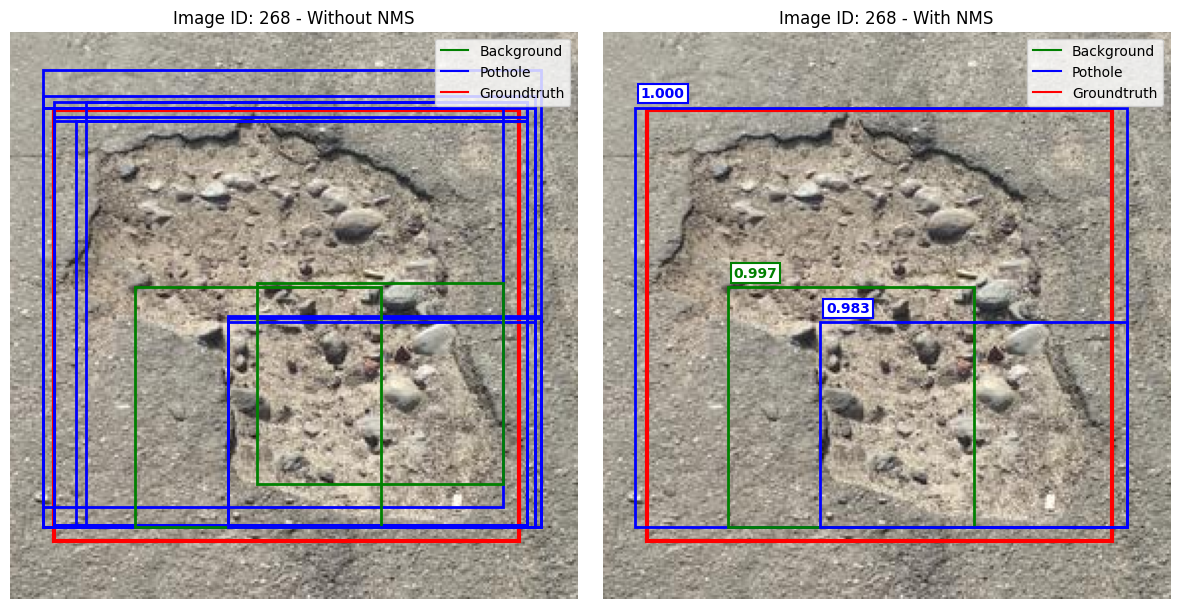

In [395]:
def visualize_detections(example_img_id, img_roi=(1,1), crop_center=(300, 400), only_nms=False, add_condifdence=False):
    img_detection = result_df[result_df['img_id'] == example_img_id]
    img_detection_without_nms = result_df_without_nms[result_df_without_nms['img_id'] == example_img_id]

    if not only_nms:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        get_img_detection_visualization(axs[0], img_detection_without_nms, subtitle="Without NMS", img_roi=img_roi, crop_center=crop_center)
        get_img_detection_visualization(axs[1], img_detection, add_condifdence, subtitle="With NMS", img_roi=img_roi, crop_center=crop_center)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        get_img_detection_visualization(ax, img_detection, add_condifdence, subtitle="With NMS")

    plt.tight_layout()
    plt.show()

# visualize_detections(205, add_condifdence=True)
visualize_detections(268, add_condifdence=True, img_roi=(0.4, 0.4), crop_center=(380, 300))

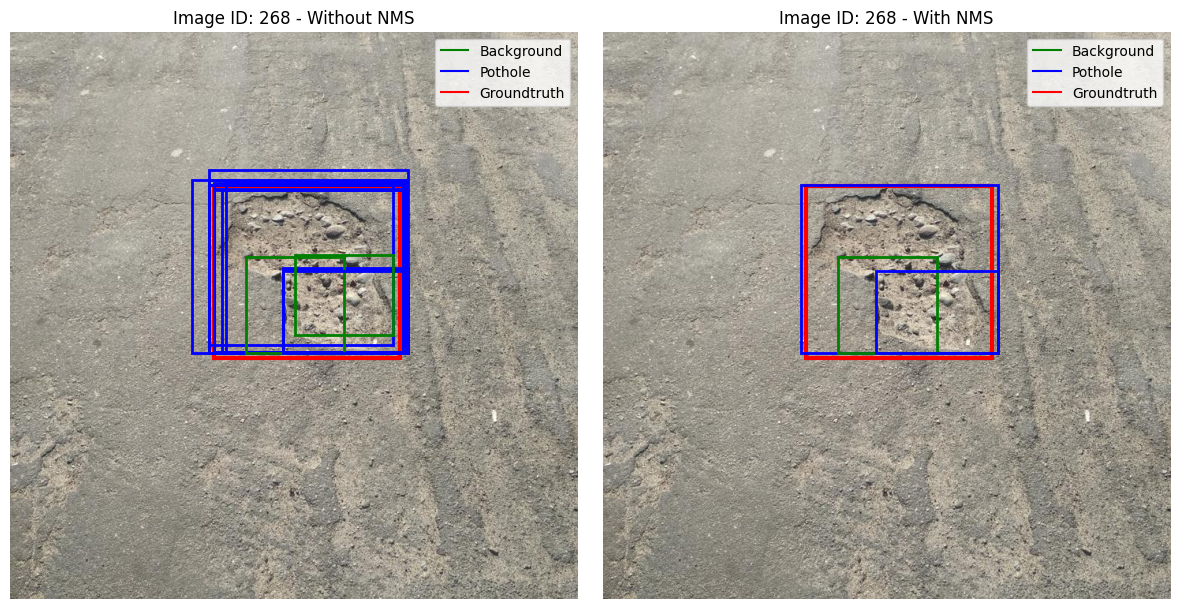

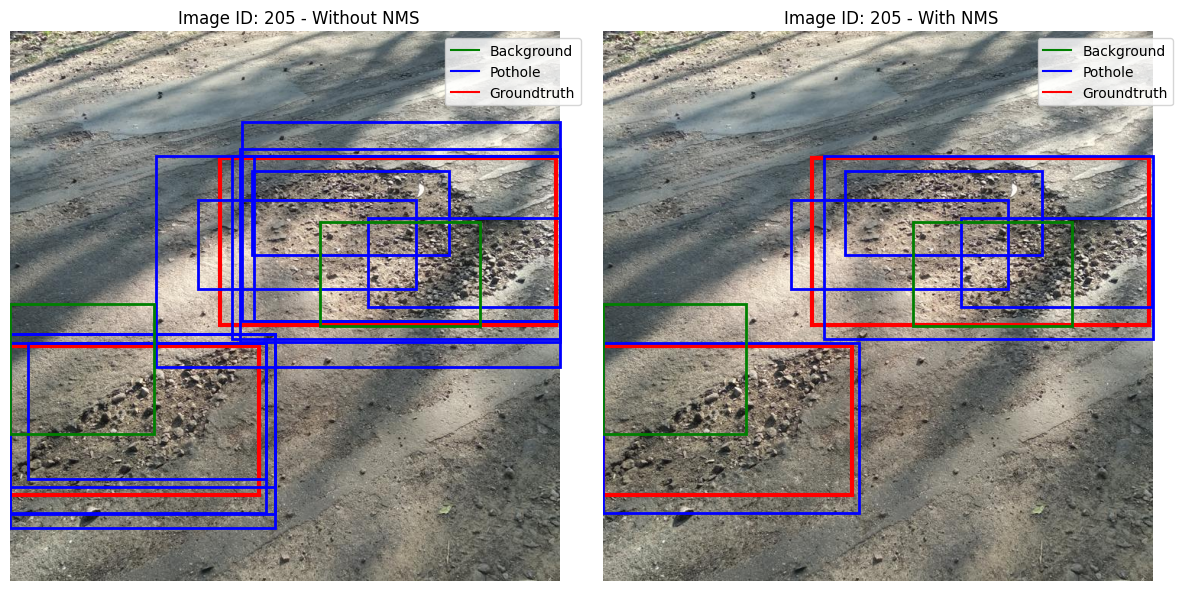

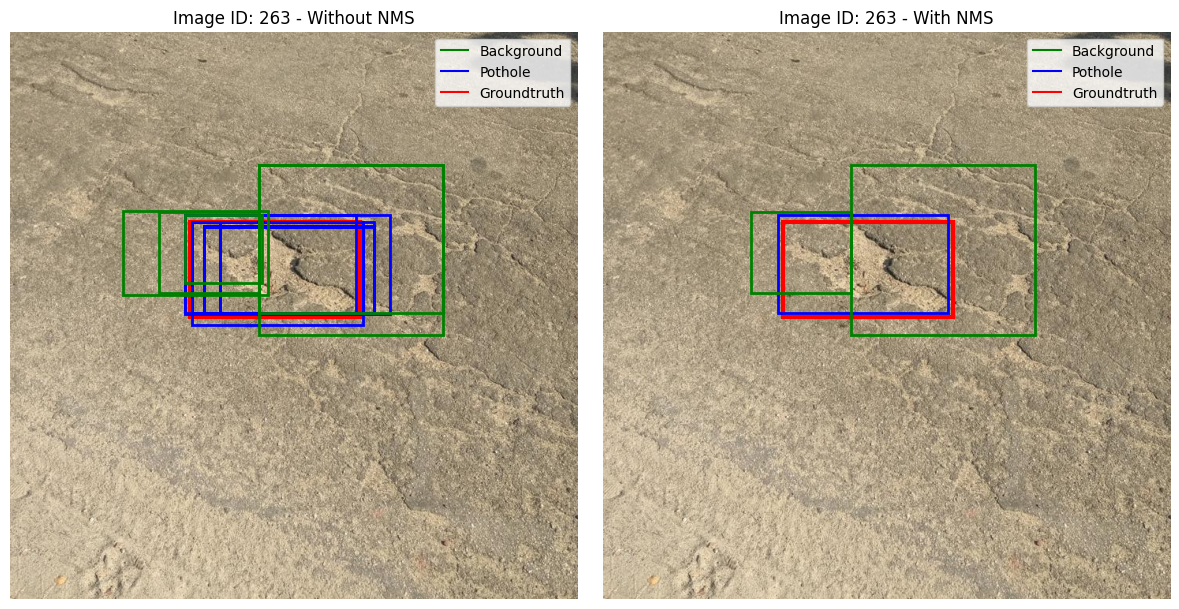

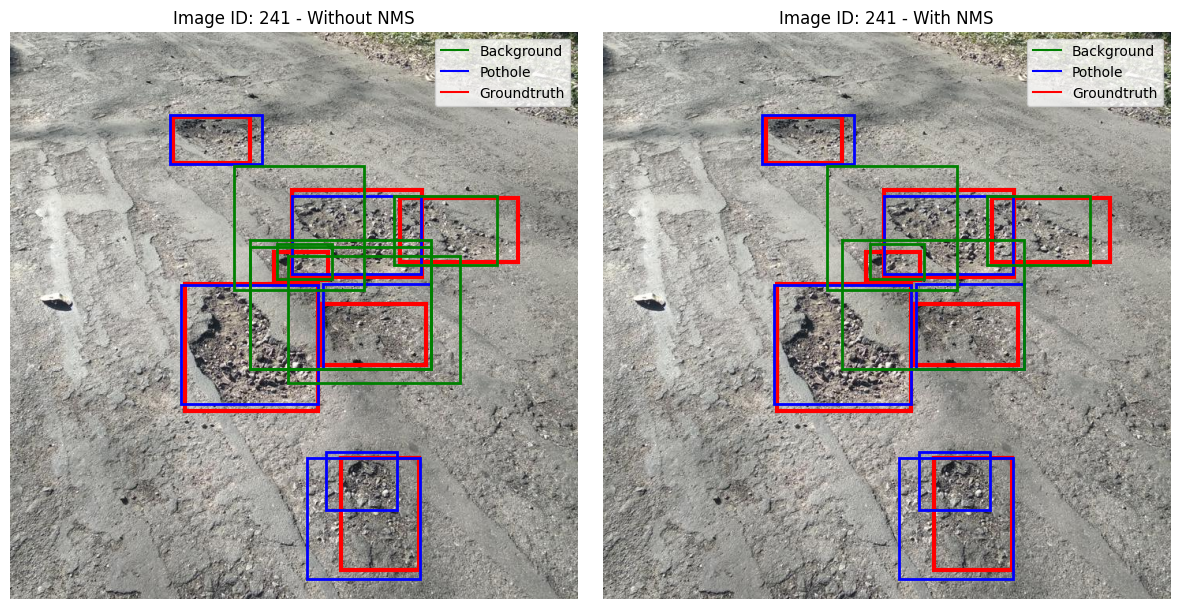

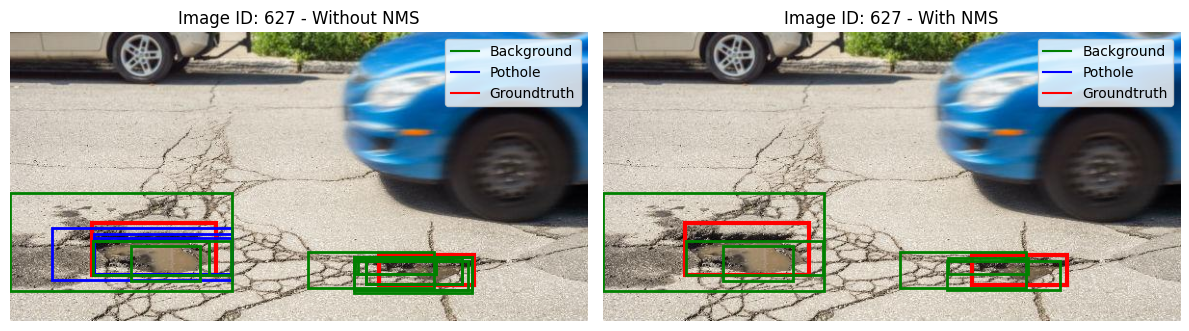

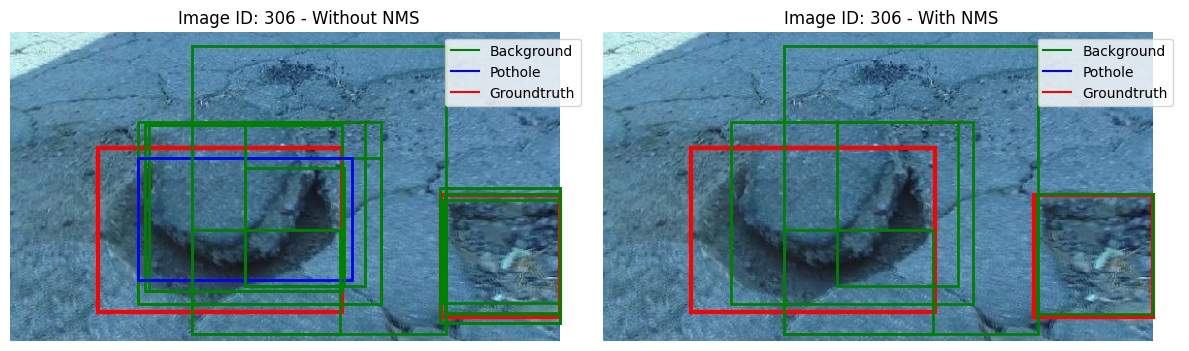

In [396]:
for i, id in enumerate(img_ids):
    if i > 5:
        break

    visualize_detections(id)

In [ ]:
result_df.head(20)

img_id                   groundtruth            proposal_path  \
0      268  [258.0, 195.0, 494.0, 414.0]   img-268_proposal_0.jpg   
1      268                          None   img-268_proposal_1.jpg   
2      268                          None   img-268_proposal_2.jpg   
3      268                          None   img-268_proposal_3.jpg   
4      268                          None   img-268_proposal_4.jpg   
5      268                          None   img-268_proposal_5.jpg   
6      268                          None   img-268_proposal_6.jpg   
7      268                          None   img-268_proposal_7.jpg   
8      268                          None   img-268_proposal_8.jpg   
9      268                          None   img-268_proposal_9.jpg   
10     268                          None  img-268_proposal_10.jpg   
11     268                          None  img-268_proposal_11.jpg   
12     268                          None  img-268_proposal_12.jpg   
13     268                          None  img-268_proposal_13.jpg   
14     268                          None  img-268_proposal_14.jpg   
15     205  [274.0, 166.0, 715.0, 384.0]   img-205_proposal_0.jpg   
16     205    [0.0, 412.0, 326.0, 607.0]   img-205_proposal_1.jpg   
17     205                          None   img-205_proposal_2.jpg   
18     205                          None   img-205_proposal_3.jpg   
19     205                          None   img-205_proposal_4.jpg   

           proposal_bbox predicted label  confidence  
0                   None       0.0     0    0.999988  
1                   None       0.0     0    0.999977  
2                   None       0.0     0    0.999975  
3   [252, 194, 502, 407]       0.0     0    0.999992  
4                   None       0.0     0    0.999984  
5                   None       0.0     0    0.999889  
6                   None       0.0     0    0.999902  
7                   None       0.0     0    0.999882  
8                   None       0.0     0    0.999909  
9                   None       0.0     0    0.999815  
10                  None       0.0     1    0.738717  
11                  None       0.0     1    0.850746  
12  [299, 285, 424, 407]       1.0     1    0.996534  
13  [346, 303, 502, 407]       0.0     1    0.982716  
14                  None       1.0     1    0.929351  
15  [290, 163, 720, 402]       0.0     0    0.999937  
16                  None       0.0     0    0.999273  
17    [0, 408, 335, 631]       0.0     0    0.999408  
18                  None       0.0     0    0.995218  
19                  None       0.0     0    0.999797

In [ ]:
gt_df = result_df[['img_id', 'groundtruth']]
gt_df = gt_df.dropna(subset=['groundtruth'])
gt_df = gt_df.reset_index(drop=True)

gt_df.head()

img_id                   groundtruth
0     268  [258.0, 195.0, 494.0, 414.0]
1     205  [274.0, 166.0, 715.0, 384.0]
2     205    [0.0, 412.0, 326.0, 607.0]
3     263  [228.0, 241.0, 444.0, 362.0]
4     241  [207.0, 108.0, 304.0, 166.0]

In [ ]:
proposals_df = result_df[['img_id', 'proposal_bbox', 'predicted', 'confidence']]
proposals_df = proposals_df.dropna(subset=['proposal_bbox'])
proposals_df = proposals_df.drop(proposals_df[proposals_df['predicted'] == 1].index)
proposals_df = proposals_df.reset_index(drop=True)

proposals_df.head()

img_id         proposal_bbox predicted  confidence
0     268  [252, 194, 502, 407]       0.0    0.999992
1     268  [346, 303, 502, 407]       0.0    0.982716
2     205  [290, 163, 720, 402]       0.0    0.999937
3     205    [0, 408, 335, 631]       0.0    0.999408
4     205  [246, 221, 531, 337]       0.0    0.866493

In [ ]:
def calculate_ap(input_result_df, input_gt_df):
    result_df = input_result_df.copy()
    gt_df = input_gt_df.copy()
    
    # Sort all predictions by confidence in descending order
    all_predictions = result_df.sort_values(by='confidence', ascending=False)
    
    total_gt = len(gt_df)
    tp = []  # True positives
    fp = []  # False positives
    matched_gt = set()  # Keep track of matched ground truths globally
    
    # Process each prediction in order of confidence
    for _, prediction in all_predictions.iterrows():
        img_id = prediction['img_id']
        proposal_bbox = prediction['proposal_bbox']
        
        # Get all ground truths for this image
        img_gts = gt_df[gt_df['img_id'] == img_id]
        
        # Find the best matching ground truth
        max_iou = 0
        best_gt_idx = None
        
        for gt_idx, gt_row in img_gts.iterrows():
            gt_bbox = tuple(gt_row['groundtruth'])
            if gt_idx in matched_gt:
                continue
                
            iou = calculate_iou(proposal_bbox, gt_bbox)
            if iou > max_iou:
                max_iou = iou
                best_gt_idx = gt_idx
        
        # Check if we found a match above threshold
        if max_iou > 0.5 and best_gt_idx is not None:
            tp.append(1)
            fp.append(0)
            matched_gt.add(best_gt_idx)
        else:
            tp.append(0)
            fp.append(1)
    
    # Convert to numpy arrays for easier computation
    import numpy as np
    tp = np.array(tp)
    fp = np.array(fp)
    
    # Compute cumulative metrics
    cumsum_tp = np.cumsum(tp)
    cumsum_fp = np.cumsum(fp)
    
    # Calculate precision and recall at each prediction
    precision_history = cumsum_tp / (cumsum_tp + cumsum_fp)
    recall_history = cumsum_tp / total_gt
    
    # Calculate AP using all points
    # Add a start point (0,1) and end point (1,0) to precision
    precision_for_ap = np.concatenate(([1], precision_history, [0]))
    recall_for_ap = np.concatenate(([0], recall_history, [1]))
    
    # Make precision monotonically decreasing
    for i in range(len(precision_for_ap) - 1, 0, -1):
        precision_for_ap[i-1] = max(precision_for_ap[i-1], precision_for_ap[i])
    
    # Find points where recall changes
    ap = 0
    for i in range(len(recall_for_ap) - 1):
        ap += (recall_for_ap[i+1] - recall_for_ap[i]) * precision_for_ap[i+1]
    
    return ap, precision_history.tolist(), recall_history.tolist()

In [ ]:
ap, precision, recall = calculate_ap(proposals_df, gt_df)

print(ap)

0.6263228687094918


In [ ]:
def calculate_ap_with_matching_info(input_result_df, input_gt_df):
    result_df = input_result_df.copy()
    gt_df = input_gt_df.copy()
    
    # Sort all predictions by confidence in descending order
    all_predictions = result_df.sort_values(by='confidence', ascending=False)
    
    total_gt = len(gt_df)
    tp = []  # True positives
    fp = []  # False positives
    matched_gt = set()  # Keep track of matched ground truths globally
    matching_details = []  # Store details about each match
    
    # Process each prediction in order of confidence
    for _, prediction in all_predictions.iterrows():
        img_id = prediction['img_id']
        proposal_bbox = prediction['proposal_bbox']
        confidence = prediction['confidence']
        
        # Get all ground truths for this image
        img_gts = gt_df[gt_df['img_id'] == img_id]
        
        # Find the best matching ground truth
        max_iou = 0
        best_gt_idx = None
        
        for gt_idx, gt_row in img_gts.iterrows():
            gt_bbox = tuple(gt_row['groundtruth'])
            if gt_idx in matched_gt:
                continue
                
            iou = calculate_iou(proposal_bbox, gt_bbox)
            if iou > max_iou:
                max_iou = iou
                best_gt_idx = gt_idx
        
        # Store matching information
        match_info = {
            'img_id': img_id,
            'prediction_bbox': proposal_bbox,
            'confidence': confidence,
            'iou': max_iou
        }
        
        # Check if we found a match above threshold
        if max_iou > 0.5 and best_gt_idx is not None:
            tp.append(1)
            fp.append(0)
            matched_gt.add(best_gt_idx)
            match_info.update({
                'matched': True,
                'gt_bbox': tuple(gt_df.loc[best_gt_idx, 'groundtruth']),
                'gt_idx': best_gt_idx
            })
        else:
            tp.append(0)
            fp.append(1)
            match_info.update({
                'matched': False,
                'gt_bbox': None,
                'gt_idx': None
            })
        
        matching_details.append(match_info)
    
    # Get unmatched ground truths
    unmatched_gt = set(gt_df.index) - matched_gt
    unmatched_gt_info = gt_df.loc[list(unmatched_gt)][['img_id', 'groundtruth']]
    
    # Get matched ground truths
    matched_gt_info = gt_df.loc[list(matched_gt)][['img_id', 'groundtruth']]
    
    # Calculate statistics
    matching_stats = {
        'total_gt': total_gt,
        'total_matched': len(matched_gt),
        'total_unmatched': len(unmatched_gt),
        'percentage_matched': (len(matched_gt) / total_gt) * 100,
        'percentage_unmatched': (len(unmatched_gt) / total_gt) * 100,
        'matched_by_image': matched_gt_info.groupby('img_id').size().to_dict(),
        'unmatched_by_image': unmatched_gt_info.groupby('img_id').size().to_dict()
    }
    
    # Convert to numpy arrays for easier computation
    import numpy as np
    tp = np.array(tp)
    fp = np.array(fp)
    
    # Compute cumulative metrics
    cumsum_tp = np.cumsum(tp)
    cumsum_fp = np.cumsum(fp)
    
    # Calculate precision and recall at each prediction
    precision_history = cumsum_tp / (cumsum_tp + cumsum_fp)
    recall_history = cumsum_tp / total_gt
    
    # Calculate AP using all points
    precision_for_ap = np.concatenate(([1], precision_history, [0]))
    recall_for_ap = np.concatenate(([0], recall_history, [1]))
    
    # Make precision monotonically decreasing
    for i in range(len(precision_for_ap) - 1, 0, -1):
        precision_for_ap[i-1] = max(precision_for_ap[i-1], precision_for_ap[i])
    
    # Calculate AP
    ap = 0
    for i in range(len(recall_for_ap) - 1):
        ap += (recall_for_ap[i+1] - recall_for_ap[i]) * precision_for_ap[i+1]
    
    return ap, precision_history.tolist(), recall_history.tolist(), matching_details, matching_stats

def analyze_matching_results(matching_details, matching_stats):
    print("\nDetection Matching Analysis:")
    print(f"Total ground truth objects: {matching_stats['total_gt']}")
    print(f"Matched objects: {matching_stats['total_matched']} ({matching_stats['percentage_matched']:.2f}%)")
    print(f"Unmatched objects: {matching_stats['total_unmatched']} ({matching_stats['percentage_unmatched']:.2f}%)\n")
    
    print("Matched objects by image:")
    sorted_matched = sorted(matching_stats['matched_by_image'].items(), 
                          key=lambda x: (-x[1], x[0]))
    for img_id, count in sorted_matched:
        print(f"Image {img_id}: {count} matched object(s)")
    
    print("\nUnmatched objects by image:")
    sorted_unmatched = sorted(matching_stats['unmatched_by_image'].items(), 
                            key=lambda x: (-x[1], x[0]))
    for img_id, count in sorted_unmatched:
        print(f"Image {img_id}: {count} unmatched object(s)")
    
    print("\nMatching details summary:")
    import pandas as pd
    details_df = pd.DataFrame(matching_details)
    print(f"Average IoU for matched predictions: {details_df[details_df['matched']]['iou'].mean():.3f}")
    print(f"Number of false positives: {len(details_df[~details_df['matched']])}")
    
    return details_df

In [ ]:
def plot_precision_recall_curve(precision_list, recall_list, ap=None):

    recall = np.array(recall_list)
    precision = np.array(precision_list)
    
    recall = np.concatenate(([0.], recall, [1.]))
    precision = np.concatenate(([1.], precision, [0.]))
    
    for i in range(precision.size - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    
    i = np.where(recall[1:] != recall[:-1])[0]
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall[i], precision[i], 'b-', label='Precision-Recall curve')
    plt.fill_between(recall[i], 0, precision[i], alpha=0.2, color='b')
    
    if ap is not None:
        plt.text(0.6, 0.2, f'AP = {ap:.3f}', fontsize=12, color='red')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

In [ ]:
ap, precision_history, recall_history, unmatched_gt_info, unmatched_stats = calculate_ap_with_unmatched(proposals_df, gt_df)
analyze_unmatched_detections(unmatched_gt_info, unmatched_stats)


Unmatched Ground Truth Analysis:
Total unmatched objects: 88 out of 284
Percentage unmatched: 30.99%

Unmatched objects by image (sorted by number of unmatched objects):
Image 577: 5 unmatched object(s)
Image 624: 5 unmatched object(s)
Image 124: 4 unmatched object(s)
Image 232: 3 unmatched object(s)
Image 349: 3 unmatched object(s)
Image 444: 3 unmatched object(s)
Image 551: 3 unmatched object(s)
Image 76: 2 unmatched object(s)
Image 117: 2 unmatched object(s)
Image 217: 2 unmatched object(s)
Image 241: 2 unmatched object(s)
Image 306: 2 unmatched object(s)
Image 368: 2 unmatched object(s)
Image 395: 2 unmatched object(s)
Image 498: 2 unmatched object(s)
Image 564: 2 unmatched object(s)
Image 594: 2 unmatched object(s)
Image 598: 2 unmatched object(s)
Image 617: 2 unmatched object(s)
Image 627: 2 unmatched object(s)
Image 662: 2 unmatched object(s)
Image 6: 1 unmatched object(s)
Image 26: 1 unmatched object(s)
Image 28: 1 unmatched object(s)
Image 60: 1 unmatched object(s)
Image 138:

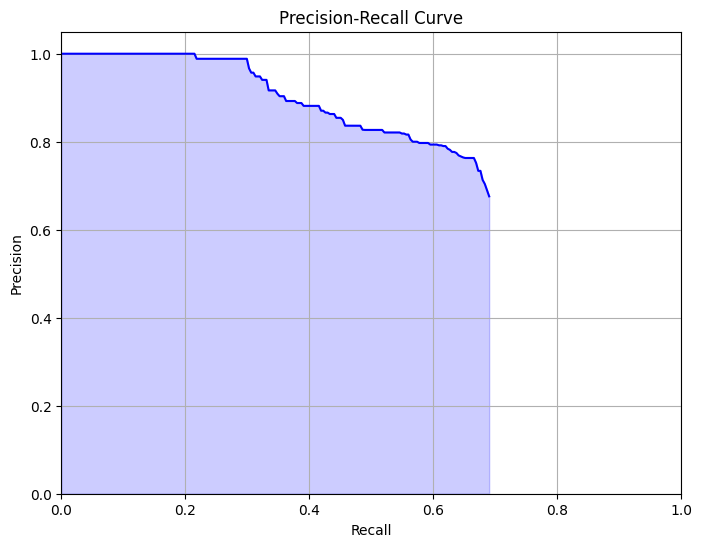

In [ ]:
plot_precision_recall_curve(precision_history, recall_history)

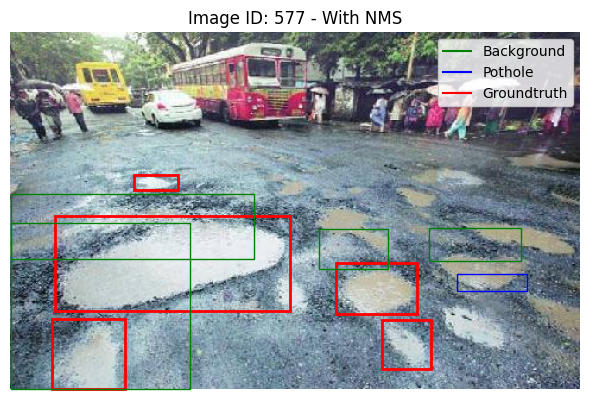

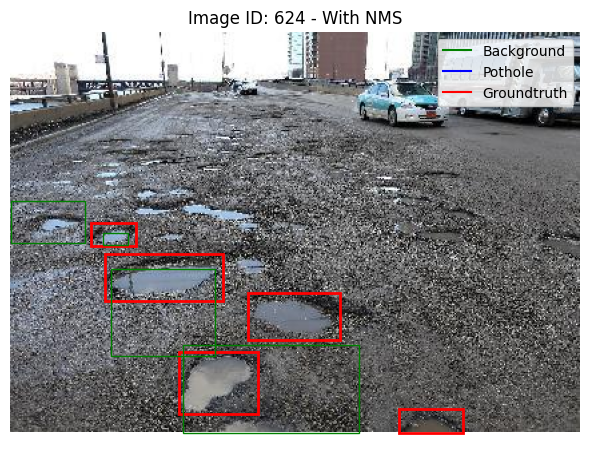

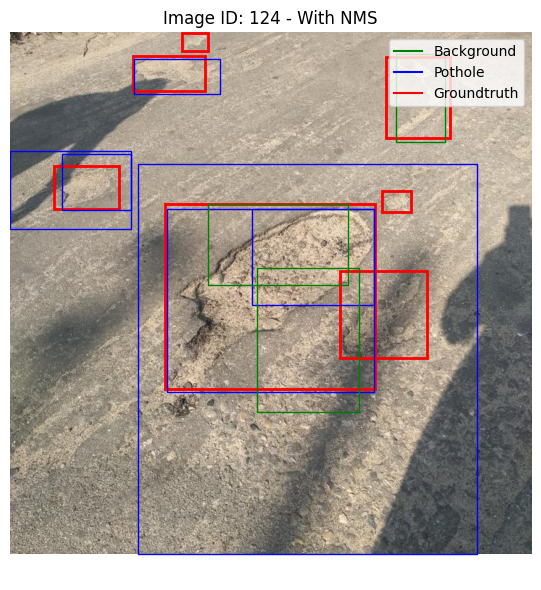

In [ ]:
visualize_detections(577, only_nms=True)

visualize_detections(624, only_nms=True)

visualize_detections(124, only_nms=True)